## Welcome to the `Segformer` Workshop!
In this workshop, we'll learn the concept of how to use Segformer (involving Transformers, Feedforward networks and MLP decoders) for Semantic Segmentation Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a Segformer MiT B3 model
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

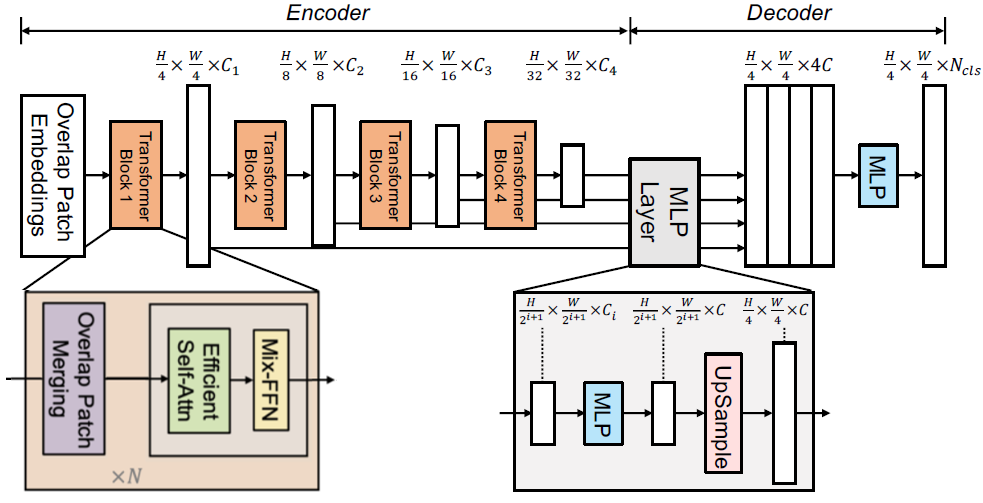

[Image reference](https://arxiv.org/abs/2105.15203)

In [1]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_
    
except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch
    
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 43.8 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ecff9dd7b2c3b2ac789dc4414c44e8e7c10862f4e2788795a69cd246bb5aaef4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=653acfbfba78f8199ed652c753f09f1d8d52a83f37d765af7a1bd8454b03cf5e
  Stored in directory

# Basic Imports

In [2]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [5]:
ENVIRONMENT = 'colab'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
    # add utils script path 
    import sys
    sys.path.append(dataset_path)
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

Mounted at /content/drive


In [6]:
targetWidth = 320
targetHeight = 180
# dataset_path = 'dataset'
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


In [7]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


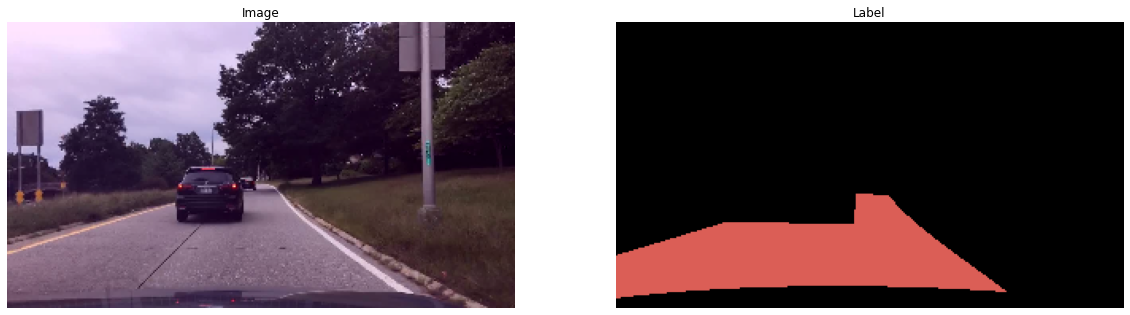

In [8]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : 

In [9]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, h, w

In [10]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        
        # Depth-wise separable convolution
        self.conv = nn.Conv2d(hidden_features, hidden_features, (3, 3), padding=(1, 1),
                              bias=True, groups=hidden_features)
        self.dropout_p = dropout_p
        
    def forward(self, x, h, w):
        x = self.fc1(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.conv(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = F.gelu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x
        

In [11]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from 
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)


    def forward(self, x, h, w):
        q = self.q(x)
        q = rearrange(q, ('b hw (m c) -> b m hw c'), m=self.num_heads)

        if self.sr_ratio > 1:
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = self.sr(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            x = self.norm(x)

        x = self.kv(x)
        x = rearrange(x, 'b d (a m c) -> a b m d c', a=2, m=self.num_heads)
        k, v = x[0], x[1] # x.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = attn @ v
        x = rearrange(x, 'b m hw c -> b hw (m c)')
        x = self.proj(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x

In [12]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, drop_path_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads, 
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)                    

        self.drop_path_p = drop_path_p
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        

    def forward(self, x, h, w):
        # Norm -> self-attention
        skip = x
        x = self.norm1(x)
        x = self.attn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip

        # Norm -> FeedForward
        skip = x
        x = self.norm2(x)
        x = self.ffn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip
        return x

In [13]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = nn.ModuleList(blocks)
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

In [14]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths, 
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm
            blocks = []
            for i in range(depths[stage_i]):
                blocks.append(transformer_block(dim = embed_dims[stage_i],
                        num_heads= num_heads[stage_i], dropout_p=dropout_p,
                        drop_path_p = drop_path_p * (sum(depths[:stage_i])+i) / (sum(depths)-1),
                        sr_ratio = sr_ratios[stage_i] ))

            if(stage_i == 0):
                patch_size = 7
                stride = 4
                in_chans = in_chans
            else:
                patch_size = 3
                stride = 2
                in_chans = embed_dims[stage_i -1]
            
            patch_embed = overlap_patch_embed(patch_size, stride=stride, in_chans=in_chans, 
                            embed_dim= embed_dims[stage_i])
            norm = nn.LayerNorm(embed_dims[stage_i], eps=1e-6)
            self.stages.append(mix_transformer_stage(patch_embed, blocks, norm))
            

    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

In [15]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(chans, embed_dim, (1, 1))
                                     for chans in reversed(in_channels)])
        self.linear_fuse = nn.Conv2d(embed_dim * len(self.layers), embed_dim, (1, 1), bias=False)
        self.bn = nn.BatchNorm2d(embed_dim, eps=1e-5)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]
        
        # project each encoder stage output to H/4, W/4
        x = [layer(xi) for layer, xi in zip(self.layers, reversed(x))]
        x = [F.interpolate(xi, size=feature_size, mode='bilinear', align_corners=False)
             for xi in x[:-1]] + [x[-1]]
        
        # concatenate project output and use 1x1
        # convs to get num_class channel output
        x = self.linear_fuse(torch.cat(x, dim=1))
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.linear_pred(x)
        return x

In [16]:
class segformer_mit_b3(nn.Module):    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block    
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512), 
                                    num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                    sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512), 
                                    num_classes=num_classes, embed_dim=256)

    def forward(self, x):
        image_hw = x.shape[2:]
        x = self.backbone(x)
        x = self.decoder_head(x)
        x = F.interpolate(x, size=image_hw, mode='bilinear', align_corners=False)
        return x

# 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [17]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

## Model Training

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# MODEL HYPERPARAMETERS
N_EPOCHS = 1
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'segformer_mit_b3'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, load imagenet pretrained weights
model = segformer_mit_b3(in_channels=3, num_classes=NUM_CLASSES).to(device)
backbone_weights = torch.load(os.path.join(dataset_path, *['segformer_mit_b3_imagenet_weights.pt']))
model.backbone.load_state_dict(backbone_weights)

<All keys matched successfully>

In [ ]:
# create optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

Starting 1 epoch ...


  5%|▌         | 15/300 [02:47<53:06, 11.18s/it]

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

In [ ]:
from utils import visualize_predictions
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples)

## Test on sample video

In [ ]:
# from utils import predict_video

# costa_rica_path = '../input/image-segmentation/videos/videos/costa_rica_challenge_360_640.avi'
# paris_video_path = '../input/image-segmentation/videos/videos/paris_challenge_360_640.avi'
# project_2_path = '../input/image-segmentation/videos/videos/project_2_360_640.avi'
# project_path = '../input/image-segmentation/videos/videos/project_360_640.avi'
# project_video_path = '../input/image-segmentation/videos/videos/project_video_360_640.avi'


# for video_path in [project_2_path, project_path]:  # costa_rica_path, paris_video_path, project_video_path
#     predict_video(model, MODEL_NAME, video_path, '.',targetWidth , targetHeight, device)

In [ ]:
# from IPython.display import HTML
# HTML("""
#     <video alt="test" controls>
#         <source src="videos/costa_rica_challenge_360_640_deeplabv3_plus_resnet50_os_output.avi" type="video/mp4">
#     </video>
# """)